In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 46.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=521b78ee12eee8273dbcb2be51ef90952056ffe24cfd9ab74e702c179997828b
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
import pandas as pd
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Stock_Market_App")\
        .getOrCreate()

stocks_df = spark.read.csv("/content/drive/MyDrive/stock_market_info.csv", header=True, inferSchema=True)

stocks_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Ticker: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Country: string (nullable = true)

root
 |-- date: string (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)



In [ ]:
stocks_df = stocks_df.drop("_c0")

stocks_df = stocks_df.withColumn('Date', to_date(col('Date'),'yyyy-MM-dd')) 

stocks_df.show(5)

+----------+------------------+------------------+------------------+------------------+------------------+-----------+------+--------------------+----------+-------+
|      Date|              Open|              High|               Low|             Close|         Adj Close|     Volume|Ticker|             Company|    Sector|Country|
+----------+------------------+------------------+------------------+------------------+------------------+-----------+------+--------------------+----------+-------+
|1999-11-18| 32.54649353027344|   35.765380859375|28.612302780151367|31.473533630371094| 27.02416229248047| 6.254638E7|     A|Agilent Technolog...|Healthcare|    USA|
|1999-11-19|30.713518142700195| 30.75822639465332| 28.47818374633789|28.880544662475586| 24.79773712158203|1.5234146E7|     A|Agilent Technolog...|Healthcare|    USA|
|1999-11-22|29.551143646240234|31.473533630371094| 28.65700912475586|31.473533630371094| 27.02416229248047|  6577870.0|     A|Agilent Technolog...|Healthcare|    USA

In [ ]:
covid_stocks_df = stocks_df.filter((stocks_df.Date >= lit('2020-01-21')) & (stocks_df.Country == 'USA'))

total_market = covid_stocks_df.groupBy('Date').sum('Adj Close').sort(asc("Date"))

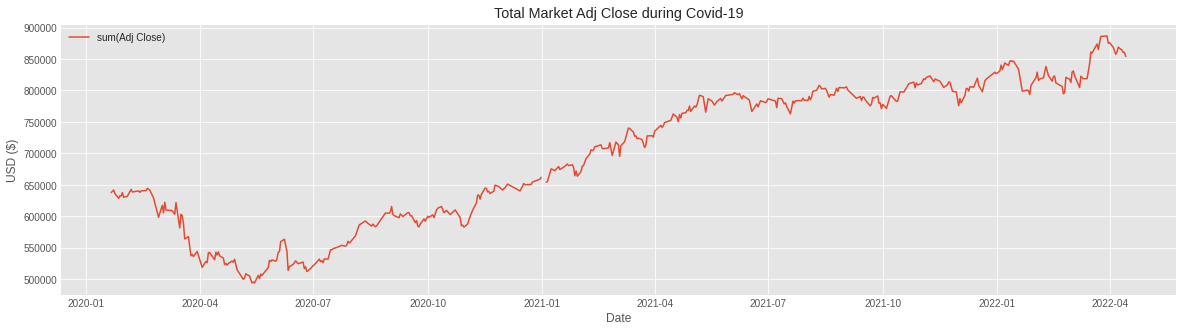

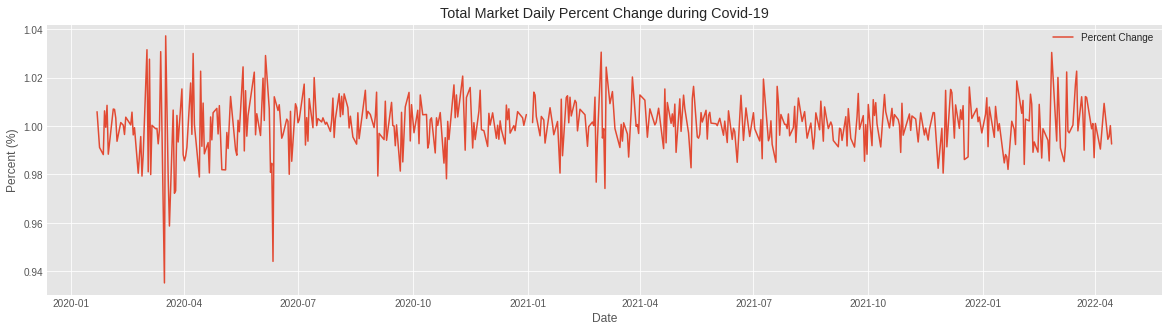

In [ ]:
pd_total_market = total_market.toPandas()

pd_total_market.plot(x = 'Date', y = 'sum(Adj Close)', xlabel = "Date", ylabel = "USD ($)", figsize = (20,5), title = "Total Market Adj Close during Covid-19")

pd_total_market_per_change = pd_total_market['sum(Adj Close)'] / (pd_total_market['sum(Adj Close)'].shift(1) - 1)

pd_total_market_per_change = pd_total_market.merge(pd_total_market_per_change.rename('Percent Change'), left_index=True, right_index=True)

pd_total_market_per_change.plot(x = 'Date', y = 'Percent Change', xlabel = "Date", ylabel = "Percent (%)", figsize = (20,5), title = "Total Market Daily Percent Change during Covid-19")


+--------------------+-------------+
|              Sector|count(Ticker)|
+--------------------+-------------+
|  Consumer Defensive|          172|
|Communication Ser...|          176|
|              Energy|          208|
|          Healthcare|          970|
|         Real Estate|          253|
|           Utilities|           82|
|         Industrials|          501|
|          Technology|          552|
|   Consumer Cyclical|          433|
|           Financial|         3473|
|     Basic Materials|          139|
+--------------------+-------------+



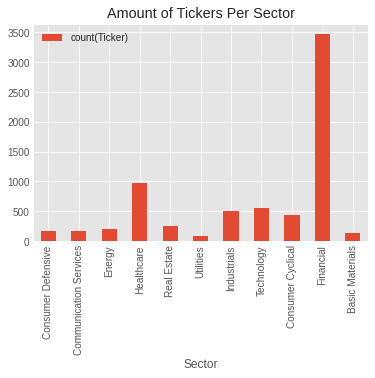

In [ ]:
sector_agg = covid_stocks_df.groupBy("Sector").agg(countDistinct("Ticker"))

sector_agg.show()

pd_sectors_agg = sector_agg.toPandas().set_index('Sector')

pd_sectors_agg.plot(kind='bar', title = "Amount of Tickers Per Sector")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f43db617310>,
      dtype=object)

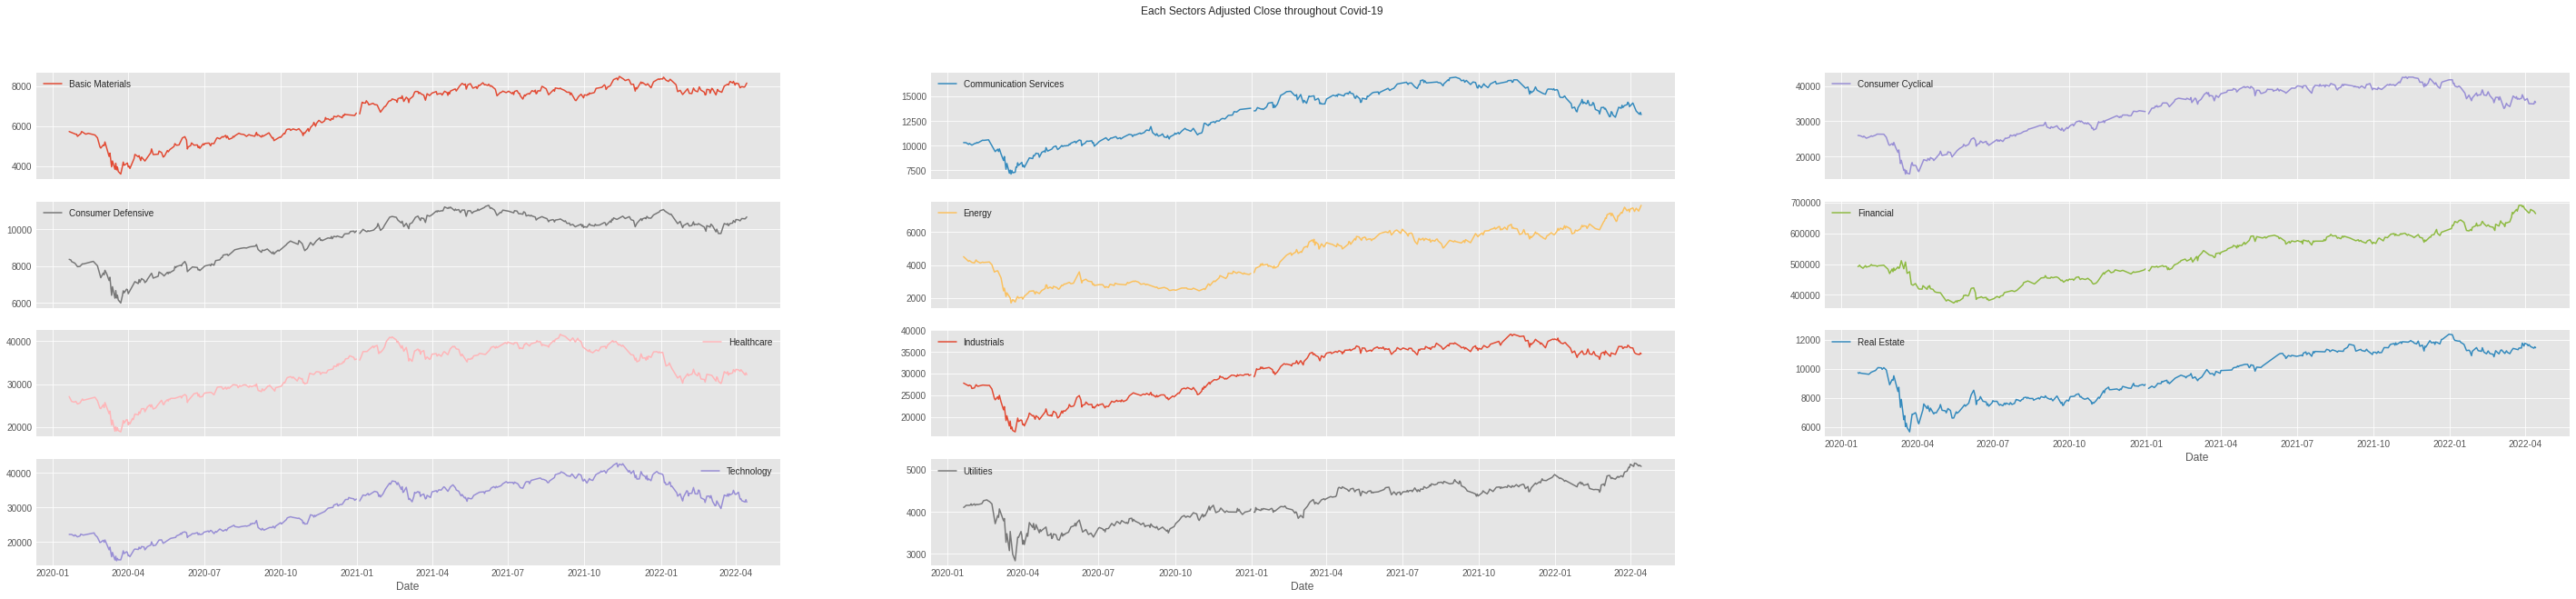

In [ ]:
sectors = covid_stocks_df.groupBy('Sector', 'Date').sum('Adj Close').sort(asc("Date"))

pd_sectors = sectors.toPandas()

pd_sectors = pd_sectors.pivot(index='Date', columns='Sector', values='sum(Adj Close)')

pd_sectors.plot(subplots=True, figsize=(50,10), layout=(4,3), title = "Each Sectors Adjusted Close throughout Covid-19")

+--------------------+------+-----------------+
|              Sector|Ticker|       Max Volume|
+--------------------+------+-----------------+
|     Basic Materials|    AA| 1.26855640798E11|
|Communication Ser...|  ABNB| 3.43860358847E11|
|   Consumer Cyclical|   AAP| 5.10294723476E11|
|  Consumer Defensive|   ACI| 1.28562103006E11|
|              Energy|    AE| 3.20685564896E11|
|           Financial|  AAAU|1.407130545648E12|
|          Healthcare|     A| 7.00378632508E11|
|         Industrials|   AAL| 3.28301733344E11|
|         Real Estate|  AAIC| 1.84465689703E11|
|          Technology|  AAOI| 6.35033103082E11|
|           Utilities|   ADN|  7.2666770867E10|
+--------------------+------+-----------------+



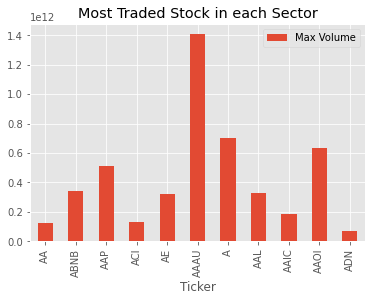

In [ ]:
most_traded_stocks = covid_stocks_df.groupBy("Sector").agg(sum("Volume"), first("Ticker").alias('Ticker'))

most_traded_stocks = most_traded_stocks.groupBy("Sector").agg(max("sum(Volume)").alias('Max Volume'), first("Ticker").alias('Ticker'))

most_traded_stocks.select('Sector', 'Ticker', 'Max Volume').show()

pd_most_traded_stocks = most_traded_stocks.toPandas().set_index('Ticker')

pd_most_traded_stocks.plot(kind='bar', title = "Most Traded Stock in each Sector")